## **Import Libraries**

In [58]:
import numpy as np
import pandas as pd
from scipy.linalg import orth

import matplotlib.pyplot as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (5, 2)
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['font.size'] = 10
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['axes.unicode_minus'] = False

## **Define functions for CoP**

In [59]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def svd_flip(u, v, u_based_decision=True):
    """Sign correction to ensure deterministic output from SVD.

    Adjusts the columns of u and the rows of v such that the loadings in the
    columns in u that are largest in absolute value are always positive.
    """
    
    if u_based_decision:
        # columns of u, rows of v
        max_abs_cols = np.argmax(np.abs(u), axis=0)
        signs = np.sign(u[max_abs_cols, range(u.shape[1])])
        u *= signs
        v *= signs[:, np.newaxis]
    else:
        # rows of v, columns of u
        max_abs_rows = np.argmax(np.abs(v), axis=1)
        signs = np.sign(v[range(v.shape[0]), max_abs_rows])
        u *= signs
        v *= signs[:, np.newaxis]
    return u, v

def coherence_pursuit(D0):
    '''
        N1 : The dimension of ambient space
        n1 : The number of inliers
        n2 : The number of outliers
        r : The rank of low rank matrix
    '''
    N1, N_sample = D0.shape

    # 1. Subtract the meidian
    D = D0 - np.median(D0, axis = 1, keepdims=True)

    # 2. Compute L2 norm of r-th columns of D0
    T = np.sum(D ** 2, axis = 0) ** 0.5 # rms amplitude
    T_aug = np.tile(T, (N1, 1)) # For element-wise division

    # 3. Normalize the columns of M0
    X = D/T_aug

    # 4. Compute the pairwise mutual coherence matrix
    G = np.matmul(X.T, X)

    # 5. Compute the coherence vector g as the L1-norm
    G = G - np.diag(np.diag(G))
    p = np.sum(G ** 2, axis = 0)
    p = p/np.max(p)


    # 7. Set # of samples by CoP algirithm to form the recovered subspace
    cut_off_th = 0.9
    n = sum(p >= cut_off_th)

    markerline, stemlines, baseline = plt.stem(sorted(p))
    plt.setp(markerline, marker='o', markersize=3, markeredgecolor="k", markeredgewidth=0.5)
    plt.setp(stemlines, linestyle="-", linewidth=0.1, color = 'lightblue')
    plt.setp(baseline, linewidth=0.5)

    plt.plot([0, N_sample],  [cut_off_th, cut_off_th], 'r:')
    plt.title('The elements of vector p')
    plt.grid(True)
    plt.show()

    print(f'Threshold for cut-off: {cut_off_th}')
    print(f'# of samples by CoP algirithm to form the recovered subspace: {n}')
    
    b = np.argsort(p)
    b = b[::-1]
    Y = D[:, b[:n]]

    index_inliners = np.zeros(N_sample)
    index_inliners[b[:n]] = 1

    # Compute the factor by Singular Value Decomposition
    U, S, Vt = np.linalg.svd(Y.T, full_matrices = False)

    # flip eigenvectors' sign to enforce deterministic output
    U, Vt = svd_flip(U, Vt)

    components_ = Vt

    # Get variance explained by singular values
    explained_variance_ = (S**2) / (n - 1)
    singular_values_ = S.copy()  # Store the singular values.

    return T, components_, singular_values_, explained_variance_, D0[:, b[:n]]

def optimal_ncluster_BIC(p, n_range = range(1, 5)):
    clusterer_list, bic_list = [], []
    for k in n_range:
        clusterer = KMeans(n_clusters = k, n_init="auto", random_state=10, max_iter=300)
        clusterer.fit(p.reshape(-1, 1))
        clusterer_list.append(clusterer)
        
        cluster_labels = clusterer.predict(p.reshape(-1, 1))
        
        bic = 0
        n = p.shape[0]
        for ind in np.unique(cluster_labels):
            temp_p = p[cluster_labels == ind]
            ni = sum(cluster_labels == ind)
            term1 = ni * np.log(ni/n)
            term2 = ni/2 * np.log(2 * np.pi)
            term3 = ni/2 * np.log(np.var(temp_p))
            term4 = (ni - k)/2
            bic = bic + term1 - term2 - term3 - term4
        
        bic = bic - 1/2 * k * np.log(n)
        bic_list.append(bic)
    

    best_ind = np.argmax(bic_list)
    best_clusterer = clusterer_list[best_ind]

    if 1:
        plt.plot(n_range, bic_list)
        plt.plot(best_ind+1, bic_list[best_ind], 'ro')
        plt.grid(True)
        plt.show()

    # 6. Perform K-means clustering and select cut-off threshold (cut_off_th)
    best_clusterer = optimal_ncluster_BIC(p)

    cluster_labels = best_clusterer.predict(p.reshape(-1, 1))
    p_target = 0
    for ind in np.unique(cluster_labels):
        temp_p = p[cluster_labels == ind]
        if temp_p.mean() > p_target:
            ind_target = ind
            p_target = temp_p.mean()

    cut_off_th = p[cluster_labels == ind_target].min()

    return best_clusterer, cut_off_th

def match_sign_vector(y_true, y):
    for i in range(y_true.shape[0]):
        if y_true[i, 0] * y[i, 0] < 0:
            y[i, :] = - y[i, :]
    return y

## **Generate Datasets**

A.shape : (2, 800)
B.shape : (2, 80)
C.shape : (2, 0)
D.shape : (2, 880)


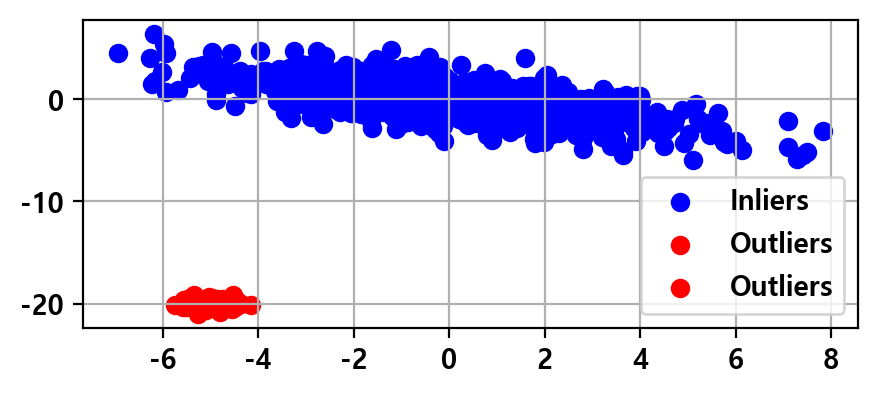

D.shape : (2, 880)


In [60]:
'''
    N1 : The dimension of ambient space
    n1 : The number of inliers
    n2 : The number of outliers
    r : The rank of low rank matrix
'''
n1, n2, r = 800, 80, 1

# Inliers
cov_inlier = np.array([[6, -3], [-3, 3.5]])
A = np.random.multivariate_normal([0, 0], cov_inlier, size=n1)
A = A.T
print(f'A.shape : {A.shape}')

# Outliers
cov_outlier = np.array([[1, 0], [0, 1]])
B = np.random.multivariate_normal([-5, -20], cov_outlier.T/10, size=n2)
# B = np.random.multivariate_normal([-25, 0], cov_outlier.T/10, size=n2)
B = B.T
print(f'B.shape : {B.shape}')

C = np.random.multivariate_normal([-15, -5], cov_outlier.T/10, size=0)
C = np.random.multivariate_normal([-15, -5], cov_outlier.T/10, size=0)
C = C.T
print(f'C.shape : {C.shape}')


# Given data
D = np.concatenate([A, B, C], axis = 1)
print(f'D.shape : {D.shape}')

plt.scatter(A[0, :], A[1, :], color = 'b', label = 'Inliers')
plt.scatter(B[0, :], B[1, :], color = 'r', label = 'Outliers')
plt.scatter(C[0, :], C[1, :], color = 'r', label = 'Outliers')
plt.legend()
plt.grid(True)
plt.show()

# Generate labels
labels = np.ones(D.shape[1])
labels[n1:] = 0

print(f'D.shape : {D.shape}')

## **Perform Coherenece Pursuit**

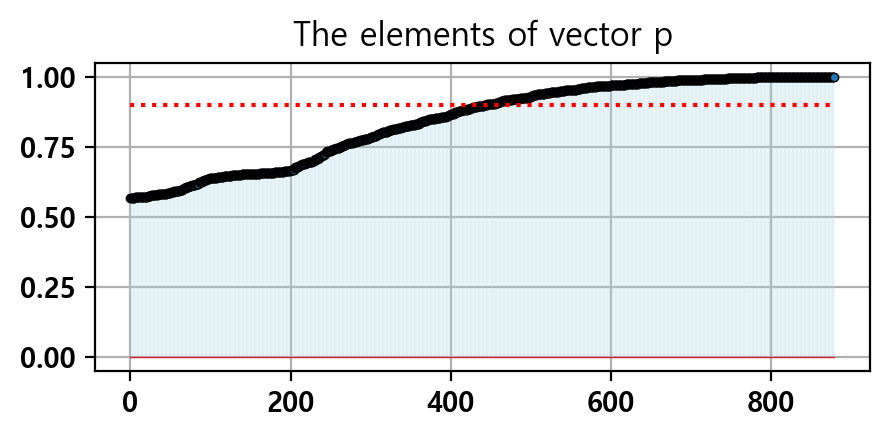

Threshold for cut-off: 0.9
# of samples by CoP algirithm to form the recovered subspace: 434
[13.28206385  0.73179147]


In [61]:
T, Cop_components_, Cop_singular_values_, Cop_explained_variance_, Cop_inliers = coherence_pursuit(D)
print(Cop_explained_variance_)

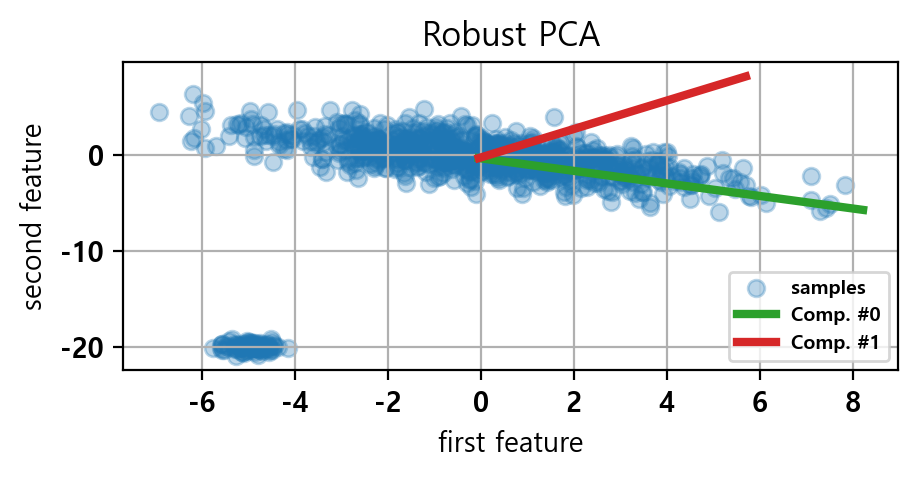

In [62]:
plt.scatter(D[0, :], D[1, :], alpha=0.3, label="samples")
# plt.scatter(Cop_inliers[0, :], Cop_inliers[1, :], alpha=0.3, label="selected samples", c = 'red')

for i, (comp, var) in enumerate(zip(Cop_components_, Cop_explained_variance_)):
    comp = comp * 10  # scale component by its variance explanation power
    plt.plot(
        [Cop_inliers[0, :].mean(), comp[0]],
        [Cop_inliers[1, :].mean(), comp[1]],
        label=f"Comp. #{i}",
        linewidth=3,
        color=f"C{i + 2}",
    )
plt.gca().set(
    # aspect="equal",
    title="Robust PCA",
    xlabel="first feature",
    ylabel="second feature",
)
plt.legend(loc = 'best', fontsize = 7)
plt.grid(True)
plt.show()

#### **Conventional PCA**

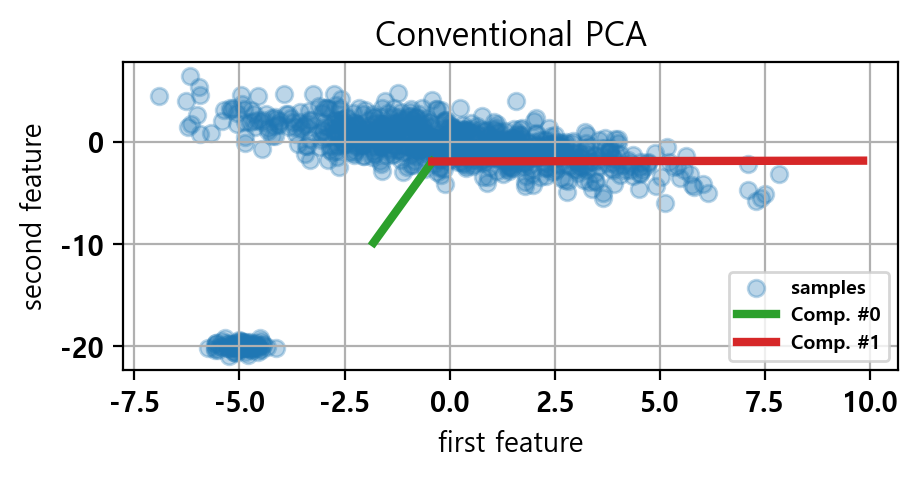

In [63]:
from sklearn.decomposition import PCA
pca_conv = PCA(n_components=2)
pca_conv.fit(D.T)

plt.scatter(D[0, :], D[1, :], alpha=0.3, label="samples")
for i, (comp, var) in enumerate(zip(pca_conv.components_, pca_conv.explained_variance_)):
    comp = comp * 10  # scale component by its variance explanation power
    plt.plot(
        [D[0, :].mean(), comp[0]],
        [D[1, :].mean(), comp[1]],
        label=f"Comp. #{i}",
        linewidth=3,
        color=f"C{i + 2}",
    )
plt.gca().set(
    # aspect="equal",
    title="Conventional PCA",
    xlabel="first feature",
    ylabel="second feature",
)
plt.legend(loc = 'best', fontsize = 7)
plt.grid(True)
plt.show()

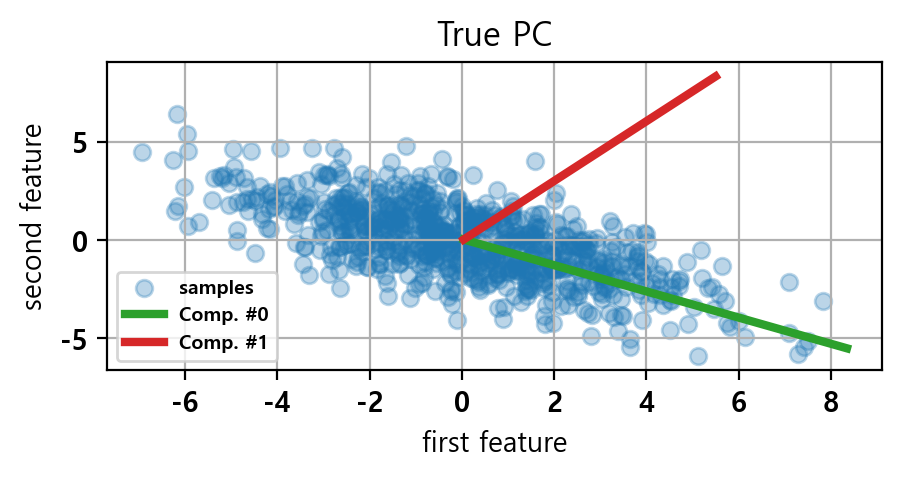

In [64]:
from sklearn.decomposition import PCA
pca_DGP = PCA(n_components=2)
pca_DGP.fit(A.T)

plt.scatter(A[0, :], A[1, :], alpha=0.3, label="samples")
for i, (comp, var) in enumerate(zip(pca_DGP.components_, pca_DGP.explained_variance_)):
    comp = comp * 10  # scale component by its variance explanation power
    plt.plot(
        [A[0, :].mean(), comp[0]],
        [A[0, :].mean(), comp[1]],
        label=f"Comp. #{i}",
        linewidth=3,
        color=f"C{i + 2}",
    )
plt.gca().set(
    # aspect="equal",
    title="True PC",
    xlabel="first feature",
    ylabel="second feature",
)
plt.legend(loc = 'best', fontsize = 7)
plt.grid(True)
plt.show()

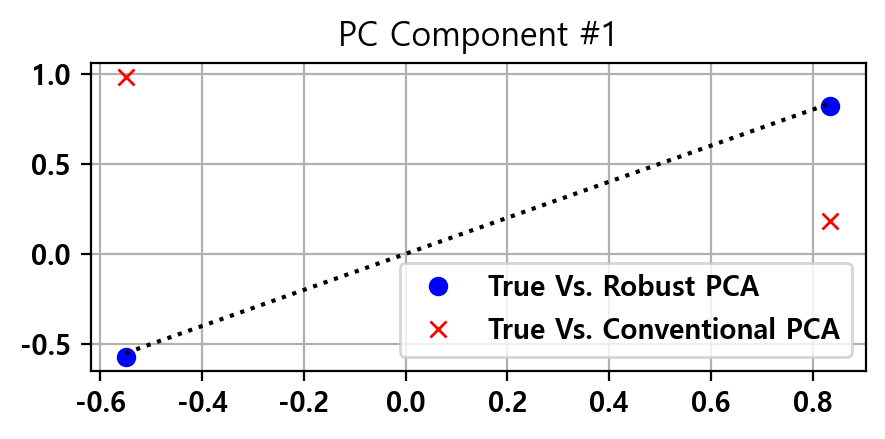

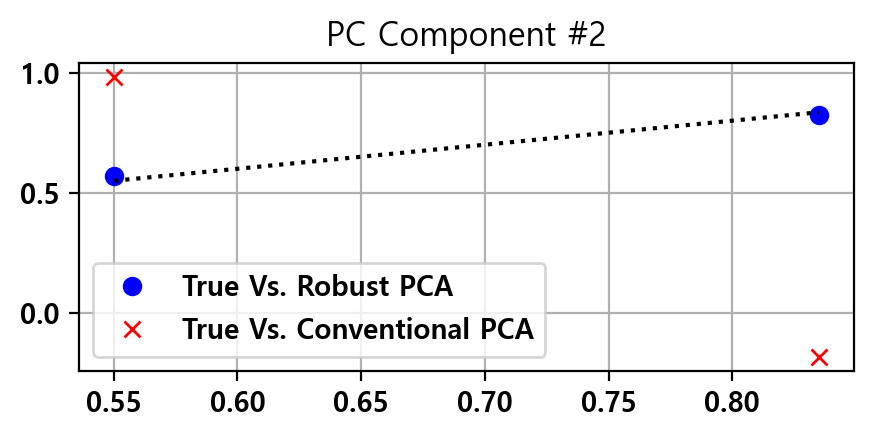

In [65]:
y_true = pca_DGP.components_

y_proposed = match_sign_vector(y_true, Cop_components_)
y_conventional = match_sign_vector(y_true, pca_conv.components_)

for i in range(2):
    plt.plot(y_true[i, :], y_proposed[i, :], 'bo', label = 'True Vs. Robust PCA')
    plt.plot(y_true[i, :], y_conventional[i, :], 'rx', label = 'True Vs. Conventional PCA')

    x_range = [y_true[i, :].min(), y_true[i, :].max()]
    plt.plot(x_range, x_range, 'k:')
    plt.title(f'PC Component #{i+1}')
    plt.grid(True)
    plt.legend()
    plt.show()